# 🔍 AI Parse Document Debug Interface

Version 1.3

Last update: Oct 6, 2025

Changelog:
- Simplified widget parameters: `input_file` and `image_output_path` now accept full volume paths
- Removed separate `catalog`, `schema`, `volume` widgets
- `input_file` supports wildcards for processing multiple files (e.g., `/Volumes/catalog/schema/volume/input/*`)

## Overview
This notebook provides a **visual debugging interface** for analyzing the output of Databricks' `ai_parse_document` function. It renders parsed documents with interactive bounding box overlays, allowing you to inspect what content was extracted from each region of your documents.

## Features
- 📊 **Visual Bounding Boxes**: Color-coded overlays showing the exact regions where text/elements were detected
- 🎯 **Interactive Tooltips**: Hover over any bounding box to see the parsed content from that region
- 📐 **Automatic Scaling**: Large documents are automatically scaled to fit within 1024px width for optimal viewing
- 🎨 **Element Type Visualization**: Different colors for different element types (text, headers, tables, figures, etc.)

## Required Parameters

This interface requires widget parameters to be configured before running:

### 1. `input_file`
- **Description**: Full Unity Catalog volume path to the document(s) you want to parse and visualize
- **Examples**:
  - Single file: `/Volumes/catalog/schema/volume/input/document.pdf`
  - All files in directory: `/Volumes/catalog/schema/volume/input/*`
  - Pattern matching: `/Volumes/catalog/schema/volume/input/*.pdf`
- **Requirements**: Read access to the volume containing your PDF/image files

### 2. `image_output_path`
- **Description**: Full Unity Catalog volume path where `ai_parse_document` will store the extracted page images
- **Example**: `/Volumes/catalog/schema/volume/output/`
- **Requirements**: Write access required for storing intermediate image outputs
- **Note**: As documented in the [official Databricks documentation](https://docs.databricks.com/aws/en/sql/language-manual/functions/ai_parse_document), this path is used by the parsing function to store page images that are referenced in the output

### 3. `page_selection`
- **Description**: Specifies which pages to display in the visualization
- **Supported formats**:
  - `"all"` or leave empty: Display all pages
  - `"3"`: Display only page 3 (1-indexed)
  - `"1-5"`: Display pages 1 through 5 (inclusive, 1-indexed)
  - `"1,3,5"`: Display specific pages (1-indexed)
  - `"1-3,7,10-12"`: Mixed ranges and individual pages

## Usage Instructions

1. **Clone this notebook** to your workspace:
   - Select **"File -> Clone"** button in the top toolbar
   - Choose your desired location in your workspace
   - This ensures you have a personal copy you can modify and run

2. **Prepare your Unity Catalog volumes**:
   - Create or identify a volume for your PDF/image files
   - Create or identify a volume for output images
   - Upload your PDF files to the input location

3. **Configure the widget parameters** at the top of this notebook:
   - Set `input_file` to the full volume path (file or directory with wildcard)
   - Set `image_output_path` to the full volume path for outputs
   - Set `page_selection` to control which pages to visualize

4. **Run all code cells** which will generate visual debugging results.

## What You'll See

- **Document Summary**: Overview of pages, element counts, and document metadata
- **Color Legend**: Visual guide showing which colors represent which element types
- **Annotated Images**: Each page with overlaid bounding boxes
  - Hover over any box to see the extracted content
  - Yellow highlight indicates the currently hovered element
- **Parsed Elements List**: Complete list of all extracted elements with their content

In [0]:
# Exec Parameters

dbutils.widgets.text("input_file", "/Volumes/main/default/source_documents/sample.pdf")
dbutils.widgets.text("image_output_path", "/Volumes/main/default/parsed_output/")
dbutils.widgets.text("page_selection", "all")

input_file = dbutils.widgets.get("input_file")
image_output_path = dbutils.widgets.get("image_output_path")
page_selection = dbutils.widgets.get("page_selection")

In [0]:
# Path configuration - use widget values as-is

source_files = input_file

#   Parse page selection string and return list of page indices to display.
#
#    Supported formats:
#    - "all" or None: Display all pages
#    - "3": Display specific page (1-indexed)
#    - "1-5": Display page range (inclusive, 1-indexed)
#    - "1,3,5": Display list of specific pages (1-indexed)
#    - "1-3,7,10-12": Mixed ranges and individual pages
page_selection = f"{page_selection}"

In [0]:
# SQL statement with ai_parse_document()
# Note: input_file can be a single file path or a directory path with wildcard
sql = f'''
with parsed_documents AS (
  SELECT
    path,
    ai_parse_document(content
     ,
    map(
     'version', '2.0',
     'imageOutputPath', '{image_output_path}',
     'descriptionElementTypes', '*'
    )
  ) as parsed
  FROM
    read_files('{source_files}', format => 'binaryFile')
)
select * from parsed_documents
'''

parsed_results = [row.parsed for row in spark.sql(sql).collect()]

In [0]:
import json
from typing import Dict, List, Any, Optional, Tuple, Set, Union
from IPython.display import HTML, display
import base64
import os
from PIL import Image
import io

class DocumentRenderer:
    def __init__(self):
        # Color mapping for different element types
        self.element_colors = {
            'section_header': '#FF6B6B',
            'text': '#4ECDC4', 
            'figure': '#45B7D1',
            'caption': '#96CEB4',
            'page_footer': '#FFEAA7',
            'page_header': '#DDA0DD',
            'table': '#98D8C8',
            'list': '#F7DC6F',
            'default': '#BDC3C7'
        }
    
    def _parse_page_selection(self, page_selection: Union[str, None], total_pages: int) -> Set[int]:
        """Parse page selection string and return set of page indices (0-based).
        
        Args:
            page_selection: Selection string or None
            total_pages: Total number of pages available
            
        Returns:
            Set of 0-based page indices to display
        """
        # Handle None or "all" - return all pages
        if page_selection is None or page_selection.lower() == "all":
            return set(range(total_pages))
        
        selected_pages = set()
        
        # Clean the input
        page_selection = page_selection.strip()
        
        # Split by commas for multiple selections
        parts = page_selection.split(',')
        
        for part in parts:
            part = part.strip()
            
            # Check if it's a range (contains hyphen)
            if '-' in part:
                try:
                    # Split range and convert to integers
                    range_parts = part.split('-')
                    if len(range_parts) == 2:
                        start = int(range_parts[0].strip())
                        end = int(range_parts[1].strip())
                        
                        # Convert from 1-indexed to 0-indexed
                        start_idx = start - 1
                        end_idx = end - 1
                        
                        # Add all pages in range (inclusive)
                        for i in range(start_idx, end_idx + 1):
                            if 0 <= i < total_pages:
                                selected_pages.add(i)
                except ValueError:
                    print(f"Warning: Invalid range '{part}' in page selection")
            else:
                # Single page number
                try:
                    page_num = int(part.strip())
                    # Convert from 1-indexed to 0-indexed
                    page_idx = page_num - 1
                    if 0 <= page_idx < total_pages:
                        selected_pages.add(page_idx)
                    else:
                        print(f"Warning: Page {page_num} is out of range (1-{total_pages})")
                except ValueError:
                    print(f"Warning: Invalid page number '{part}' in page selection")
        
        # If no valid pages were selected, default to all pages
        if not selected_pages:
            print(f"Warning: No valid pages in selection '{page_selection}'. Showing all pages.")
            return set(range(total_pages))
        
        return selected_pages
        
    def _get_element_color(self, element_type: str) -> str:
        """Get color for element type."""
        return self.element_colors.get(element_type.lower(), self.element_colors['default'])
    
    def _get_image_dimensions(self, image_path: str) -> Optional[Tuple[int, int]]:
        """Get dimensions of an image file."""
        try:
            if os.path.exists(image_path):
                with Image.open(image_path) as img:
                    return img.size  # Returns (width, height)
            return None
        except Exception as e:
            print(f"Error getting image dimensions for {image_path}: {e}")
            return None
    
    def _load_image_as_base64(self, image_path: str) -> Optional[str]:
        """Load image from file path and convert to base64."""
        try:
            if os.path.exists(image_path):
                with open(image_path, 'rb') as img_file:
                    img_data = img_file.read()
                    img_base64 = base64.b64encode(img_data).decode('utf-8')
                    ext = os.path.splitext(image_path)[1].lower()
                    if ext in ['.jpg', '.jpeg']:
                        return f"data:image/jpeg;base64,{img_base64}"
                    elif ext in ['.png']:
                        return f"data:image/png;base64,{img_base64}"
                    else:
                        return f"data:image/jpeg;base64,{img_base64}"
            return None
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None
    
    def _render_element_content(self, element: Dict, for_tooltip: bool = False) -> str:
        """Render element content with appropriate formatting for both tooltip and element list display.
        
        Args:
            element: The element dictionary containing content/description
            for_tooltip: Whether this is for tooltip display (affects styling and truncation)
        """
        element_type = element.get('type', 'unknown')
        content = element.get('content', '')
        description = element.get('description', '')
        
        display_content = ""
        
        if content:
            if element_type == 'table':
                # Render the HTML table with styling
                table_html = content
                
                # Apply different styling based on context
                if for_tooltip:
                    # Compact styling for tooltips with light theme
                    # Use full width available for tooltip tables
                    table_style = f'''style="width: 100%; border-collapse: collapse; margin: 5px 0; font-size: 10px;"'''
                    th_style = 'style="border: 1px solid #ddd; padding: 4px; background: #f8f9fa; color: #333; font-weight: bold; text-align: left; font-size: 10px;"'
                    td_style = 'style="border: 1px solid #ddd; padding: 4px; color: #333; font-size: 10px;"'
                    thead_style = 'style="background: #e9ecef;"'
                else:
                    # Full styling for element list
                    table_style = '''style="width: 100%; border-collapse: collapse; margin: 10px 0; font-size: 13px;"'''
                    th_style = 'style="border: 1px solid #ddd; padding: 8px; background: #f5f5f5; font-weight: bold; text-align: left;"'
                    td_style = 'style="border: 1px solid #ddd; padding: 8px;"'
                    thead_style = 'style="background: #f0f0f0;"'
                
                # Apply styling transformations
                if '<table>' in table_html:
                    table_html = table_html.replace('<table>', f'<table {table_style}>')
                if '<th>' in table_html:
                    table_html = table_html.replace('<th>', f'<th {th_style}>')
                if '<td>' in table_html:
                    table_html = table_html.replace('<td>', f'<td {td_style}>')
                if '<thead>' in table_html:
                    table_html = table_html.replace('<thead>', f'<thead {thead_style}>')
                
                if for_tooltip:
                    display_content = table_html
                else:
                    display_content = f"<div style='overflow-x: auto; margin: 10px 0;'>{table_html}</div>"
            else:
                # Regular content handling
                if for_tooltip and len(content) > 500:
                    # Truncate for tooltip display and escape HTML for safety
                    display_content = self._escape_for_html_attribute(content[:500] + "...")
                else:
                    display_content = self._escape_for_html_attribute(content) if for_tooltip else content
        elif description:
            desc_content = description
            if for_tooltip and len(desc_content) > 500:
                desc_content = desc_content[:500] + "..."
            
            if for_tooltip:
                display_content = self._escape_for_html_attribute(f"Description: {desc_content}")
            else:
                display_content = f"<em>Description: {desc_content}</em>"
        else:
            display_content = "No content available" if for_tooltip else "<em>No content</em>"
        
        return display_content
    
    def _escape_for_html_attribute(self, text: str) -> str:
        """Escape text for safe use in HTML attributes."""
        return (text.replace('&', '&amp;')
                   .replace('<', '&lt;')
                   .replace('>', '&gt;')
                   .replace('"', '&quot;')
                   .replace("'", '&#39;')
                   .replace('\n', '<br>'))
    
    def _calculate_tooltip_width(self, element: Dict, image_width: int) -> int:
        """Calculate dynamic tooltip width based on table content."""
        element_type = element.get('type', 'unknown')
        content = element.get('content', '')
        
        if element_type == 'table' and content:
            # Count columns by looking for <th> or <td> tags in first row
            import re
            
            # Find first row (either in thead or tbody)
            first_row_match = re.search(r'<tr[^>]*>(.*?)</tr>', content, re.DOTALL | re.IGNORECASE)
            if first_row_match:
                first_row = first_row_match.group(1)
                # Count th or td tags
                th_count = len(re.findall(r'<th[^>]*>', first_row, re.IGNORECASE))
                td_count = len(re.findall(r'<td[^>]*>', first_row, re.IGNORECASE))
                column_count = max(th_count, td_count)
                
                if column_count > 0:
                    # Base width + additional width per column
                    base_width = 300
                    width_per_column = 80
                    calculated_width = base_width + (column_count * width_per_column)
                    
                    # Cap at 4/5th of image width
                    max_width = int(image_width * 0.8)
                    return min(calculated_width, max_width)
        
        # Default width for non-tables or when calculation fails
        return 400
    
    def _create_annotated_image(self, page: Dict, elements: List[Dict]) -> str:
        """Create annotated image with SCALING to fit within 1024px width."""
        image_uri = page.get('image_uri', '')
        page_id = page.get('id', 0)
        
        if not image_uri:
            return "<p style='color: red;'>No image URI found for this page</p>"
        
        # Load image
        img_data_uri = self._load_image_as_base64(image_uri)
        if not img_data_uri:
            return f"""
            <div style="background: #f8d7da; border: 1px solid #f5c6cb; color: #721c24; padding: 15px; border-radius: 5px;">
                <strong>Could not load image:</strong> {image_uri}<br>
                <small>Make sure the file exists and is accessible.</small>
            </div>
            """
        
        # Get original image dimensions
        original_dimensions = self._get_image_dimensions(image_uri)
        if not original_dimensions:
            # Fallback: display without explicit scaling
            original_width, original_height = 1024, 768  # Default fallback
        else:
            original_width, original_height = original_dimensions
        
        # Calculate scaling factor to fit within 1024px width
        max_display_width = 1024
        scale_factor = 1.0
        display_width = original_width
        display_height = original_height
        
        if original_width > max_display_width:
            scale_factor = max_display_width / original_width
            display_width = max_display_width
            display_height = int(original_height * scale_factor)
        
        # Filter elements for this page and collect their bounding boxes
        page_elements = []
        
        for elem in elements:
            elem_bboxes = []
            for bbox in elem.get('bbox', []):
                if bbox.get('page_id', 0) == page_id:
                    coord = bbox.get('coord', [])
                    if len(coord) >= 4:
                        elem_bboxes.append(bbox)
            
            if elem_bboxes:
                page_elements.append({
                    'element': elem,
                    'bboxes': elem_bboxes
                })
        
        if not page_elements:
            return f"<p>No elements found for page {page_id}</p>"
                
        header_info = f"""
        <div style="background: #e3f2fd; border: 1px solid #2196f3; border-radius: 8px; padding: 15px; margin: 10px 0;">
            <strong>Page {page_id + 1}: {len(page_elements)} elements</strong><br>
            <strong>Original size:</strong> {original_width}×{original_height}px | 
            <strong>Display size:</strong> {display_width}×{display_height}px | 
            <strong>Scale factor:</strong> {scale_factor:.3f}<br>
        </div>
        """
        
        # Generate unique container ID for this page
        container_id = f"page_container_{page_id}_{id(self)}"
        
        # Create bounding box overlays using SCALED coordinates with hover functionality
        overlays = []
        
        for idx, item in enumerate(page_elements):
            element = item['element']
            element_id = element.get('id', 'N/A')
            element_type = element.get('type', 'unknown')
            color = self._get_element_color(element_type)
            
            # Use the shared content renderer for tooltip
            tooltip_content = self._render_element_content(element, for_tooltip=True)
            
            # Calculate dynamic tooltip width
            tooltip_width = self._calculate_tooltip_width(element, display_width)
            
            # Tables should render as HTML, other content should be escaped
            
            for bbox_idx, bbox in enumerate(item['bboxes']):
                coord = bbox.get('coord', [])
                if len(coord) >= 4:
                    x1, y1, x2, y2 = coord
                    
                    # Apply scaling to coordinates
                    scaled_x1 = x1 * scale_factor
                    scaled_y1 = y1 * scale_factor
                    scaled_x2 = x2 * scale_factor
                    scaled_y2 = y2 * scale_factor
                    
                    width = scaled_x2 - scaled_x1
                    height = scaled_y2 - scaled_y1
                    
                    # Skip invalid boxes
                    if width <= 0 or height <= 0:
                        continue
                    
                    # Position label above box when possible
                    label_top = -18 if scaled_y1 >= 18 else 2
                    
                    # Unique ID for this bounding box
                    box_id = f"bbox_{page_id}_{idx}_{bbox_idx}"
                    
                    # Calculate tooltip position (prefer right side, but switch to left if needed)
                    tooltip_left = 10
                    
                    overlay = f"""
                    <div id="{box_id}" 
                         class="bbox-overlay bbox-{container_id}"
                         style="position: absolute; 
                               left: {scaled_x1:.1f}px; top: {scaled_y1:.1f}px; 
                               width: {width:.1f}px; height: {height:.1f}px;
                               border: 2px solid {color};
                               background: {color}25;
                               box-sizing: border-box;
                               cursor: pointer;
                               transition: all 0.2s ease;">
                        <div style="background: {color}; color: white; 
                                   padding: 1px 4px; font-size: 9px; font-weight: bold;
                                   position: absolute; top: {label_top}px; left: 0;
                                   white-space: nowrap; border-radius: 2px;
                                   box-shadow: 0 1px 2px rgba(0,0,0,0.3);
                                   pointer-events: none;
                                   max-width: {max(50, width-4):.0f}px;
                                   overflow: hidden;
                                   z-index: 1000;">
                            {element_type.upper()[:6]}#{element_id}
                        </div>
                        <!-- Tooltip as child element (CSS hover approach) -->
                        <div class="bbox-tooltip" style="
                            position: absolute;
                            left: {tooltip_left}px;
                            top: {height};
                            background: rgba(255, 255, 255, 0.98);
                            color: #333;
                            border: 2px solid #ccc;
                            padding: 12px;
                            border-radius: 6px;
                            font-size: 12px;
                            width: {tooltip_width}px;
                            max-width: {tooltip_width}px;
                            word-wrap: break-word;
                            z-index: 10000;
                            pointer-events: none;
                            box-shadow: 0 4px 12px rgba(0, 0, 0, 0.15);
                            display: none;
                            line-height: 1.4;
                            max-height: 400px;
                            overflow-y: auto;">
                            <div style="font-weight: bold; color: #0066cc; margin-bottom: 8px; padding-bottom: 6px; border-bottom: 1px solid #ddd;">
                                {element_type.upper()} #{element_id}
                            </div>
                            <div style="font-family: 'Segoe UI', 'Helvetica Neue', Arial, sans-serif; font-size: 11px;">
                                {tooltip_content}
                            </div>
                        </div>
                    </div>
                    """
                    overlays.append(overlay)
        
        # Pure CSS hover functionality (works in Databricks)
        styles = f"""
        <style>
            /* Hover effect for bounding boxes */
            .bbox-{container_id}:hover {{
                background: rgba(255, 255, 0, 0.3) !important;
                border-width: 3px !important;
                z-index: 1001 !important;
            }}
            
            /* Show tooltip on hover using pure CSS */
            .bbox-{container_id}:hover .bbox-tooltip {{
                display: block !important;
            }}
            
            /* Ensure tooltips appear above other elements */
            .bbox-{container_id} {{
                z-index: 100;
            }}
            
            .bbox-{container_id}:hover {{
                z-index: 9999 !important;
            }}
        </style>
        """
        
        return f"""
        {header_info}
        {styles}
        <div id="{container_id}" style="position: relative; display: inline-block; border: 2px solid #333; border-radius: 8px; overflow: visible; background: white;">
            <img src="{img_data_uri}" 
                 style="display: block; width: {display_width}px; height: {display_height}px;" 
                 alt="Page {page_id + 1}">
            {''.join(overlays)}
        </div>
        """
    
    def _create_page_elements_list(self, page_id: int, elements: List[Dict]) -> str:
        """Create a detailed list of elements for a specific page."""
        # Filter elements for this page
        page_elements = []
        
        for elem in elements:
            elem_bboxes = []
            for bbox in elem.get('bbox', []):
                if bbox.get('page_id', 0) == page_id:
                    elem_bboxes.append(bbox)
            
            if elem_bboxes:
                page_elements.append(elem)
        
        if not page_elements:
            return f"<p>No elements found for page {page_id + 1}</p>"
        
        html_parts = []
        
        for element in page_elements:
            element_id = element.get('id', 'N/A')
            element_type = element.get('type', 'unknown')
            color = self._get_element_color(element_type)
            
            # Get bounding box info for this page only
            bbox_info = "No bbox"
            bbox_list = element.get('bbox', [])
            if bbox_list:
                bbox_details = []
                for bbox in bbox_list:
                    if bbox.get('page_id', 0) == page_id:
                        coord = bbox.get('coord', [])
                        if len(coord) >= 4:
                            bbox_details.append(f"[{coord[0]:.0f}, {coord[1]:.0f}, {coord[2]:.0f}, {coord[3]:.0f}]")
                bbox_info = "; ".join(bbox_details) if bbox_details else "Invalid bbox"
            
            # Use the shared content renderer for element list display
            display_content = self._render_element_content(element, for_tooltip=False)
            
            element_html = f"""
            <div style="border-left: 5px solid {color}; 
                       padding: 15px; margin: 15px 0; 
                       background: {color}15; border-radius: 5px;">
                <div style="display: flex; justify-content: space-between; align-items: flex-start; margin-bottom: 10px;">
                    <h4 style="margin: 0; color: {color}; font-size: 16px;">
                        {element_type.upper().replace('_', ' ')} (ID: {element_id})
                    </h4>
                    <code style="background: #f5f5f5; padding: 3px 6px; border-radius: 3px; font-size: 10px; max-width: 300px; word-break: break-all;">
                        {bbox_info}
                    </code>
                </div>
                <div style="font-size: 14px; line-height: 1.4;">
                    {display_content}
                </div>
            </div>
            """
            html_parts.append(element_html)
        
        return f"""
        <div style="margin: 20px 0;">
            <h3 style="color: #333; margin-bottom: 15px;">📋 Page {page_id + 1} Elements ({len(page_elements)} items)</h3>
            {''.join(html_parts)}
        </div>
        """
    
    def _create_summary(self, document: Dict, metadata: Dict, selected_pages: Set[int], total_pages: int) -> str:
        """Create a summary with page selection info."""
        elements = document.get('elements', [])
        
        # Count elements only on selected pages
        selected_elements = []
        for elem in elements:
            for bbox in elem.get('bbox', []):
                if bbox.get('page_id', 0) in selected_pages:
                    selected_elements.append(elem)
                    break
        
        # Count by type (for selected pages)
        type_counts = {}
        for elem in selected_elements:
            elem_type = elem.get('type', 'unknown')
            type_counts[elem_type] = type_counts.get(elem_type, 0) + 1
        
        type_list = ', '.join([f"{t}: {c}" for t, c in type_counts.items()])
        
        # Create page selection info
        if len(selected_pages) == total_pages:
            page_info = f"All {total_pages} pages"
        else:
            # Convert to 1-indexed for display
            page_nums = sorted([p + 1 for p in selected_pages])
            if len(page_nums) <= 10:
                page_info = f"Pages {', '.join(map(str, page_nums))} ({len(selected_pages)} of {total_pages})"
            else:
                page_info = f"{len(selected_pages)} of {total_pages} pages selected"
        
        return f"""
        <div style="background: #e3f2fd; border: 1px solid #2196f3; border-radius: 8px; padding: 20px; margin: 15px 0;">
            <h3 style="margin: 0 0 10px 0; color: #1976d2;">📄 Document Summary</h3>
            <p><strong>Displaying:</strong> {page_info}</p>
            <p><strong>Elements on selected pages:</strong> {len(selected_elements)}</p>
            <p><strong>Element Types:</strong> {type_list if type_list else 'None'}</p>
            <p><strong>Document ID:</strong> {str(metadata.get('id', 'N/A'))[:12]}...</p>
        </div>
        """
    
    def render_document(self, parsed_result: Any, page_selection: Union[str, None] = None) -> None:
        """Main render function with page selection support.
        
        Args:
            parsed_result: The parsed document result
            page_selection: Page selection string. Supported formats:
                - "all" or None: Display all pages
                - "3": Display only page 3 (1-indexed)
                - "1-5": Display pages 1 through 5 (inclusive)
                - "1,3,5": Display specific pages
                - "1-3,7,10-12": Mixed format
        """
        try:
            # Convert to dict
            if hasattr(parsed_result, 'toPython'):
                parsed_dict = parsed_result.toPython()
            elif hasattr(parsed_result, 'toJson'):
                parsed_dict = json.loads(parsed_result.toJson())
            elif isinstance(parsed_result, dict):
                parsed_dict = parsed_result
            else:
                display(HTML(f"<p style='color: red;'>❌ Could not convert result. Type: {type(parsed_result)}</p>"))
                return
            
            # Extract components
            document = parsed_dict.get('document', {})
            pages = document.get('pages', [])
            elements = document.get('elements', [])
            metadata = parsed_dict.get('metadata', {})
            
            if not elements:
                display(HTML("<p style='color: red;'>❌ No elements found in document</p>"))
                return
            
            # Parse page selection
            selected_pages = self._parse_page_selection(page_selection, len(pages))
            
            # Display title
            display(HTML("<h1>🔍 AI Parse Document Results</h1>"))
            
            # Display summary with page selection info
            summary_html = self._create_summary(document, metadata, selected_pages, len(pages))
            display(HTML(summary_html))
            
            # Display color legend
            legend_items = []
            for elem_type, color in self.element_colors.items():
                if elem_type != 'default':
                    legend_items.append(f"""
                        <span style="display: inline-block; margin: 5px;">
                            <span style="display: inline-block; width: 15px; height: 15px; 
                                        background: {color}; border: 1px solid #999; margin-right: 5px;"></span>
                            {elem_type.replace('_', ' ').title()}
                        </span>
                    """)
            
            display(HTML(f"""
            <div style="background: #f9f9f9; padding: 15px; border-radius: 5px; margin: 15px 0;">
                <strong>🎨 Element Colors:</strong><br>
                {''.join(legend_items)}
            </div>
            """))
            
            # Display annotated images with their corresponding elements (filtered by selection)
            if pages:
                display(HTML("<h2>🖼️ Annotated Images & Elements</h2>"))
                
                # Sort selected pages for display
                sorted_selected = sorted(selected_pages)
                
                for page_idx in sorted_selected:
                    if page_idx < len(pages):
                        page = pages[page_idx]
                        
                        # Display the annotated image
                        annotated_html = self._create_annotated_image(page, elements)
                        display(HTML(f"<div style='margin: 20px 0;'>{annotated_html}</div>"))
                        
                        # Display elements for this page immediately after the image
                        page_id = page.get('id', page_idx)
                        page_elements_html = self._create_page_elements_list(page_id, elements)
                        display(HTML(page_elements_html))
            
        except Exception as e:
            display(HTML(f"<p style='color: red;'>❌ Error: {str(e)}</p>"))
            import traceback
            display(HTML(f"<pre>{traceback.format_exc()}</pre>"))


# Simple usage functions
def render_ai_parse_output(parsed_result, page_selection=None):
    """Simple function to render ai_parse_document output with page selection.
    
    Args:
        parsed_result: The parsed document result
        page_selection: Optional page selection string. Examples:
            - None or "all": Display all pages
            - "3": Display only page 3
            - "1-5": Display pages 1 through 5
            - "1,3,5": Display specific pages
            - "1-3,7,10-12": Mixed format
    """
    renderer = DocumentRenderer()
    renderer.render_document(parsed_result, page_selection)


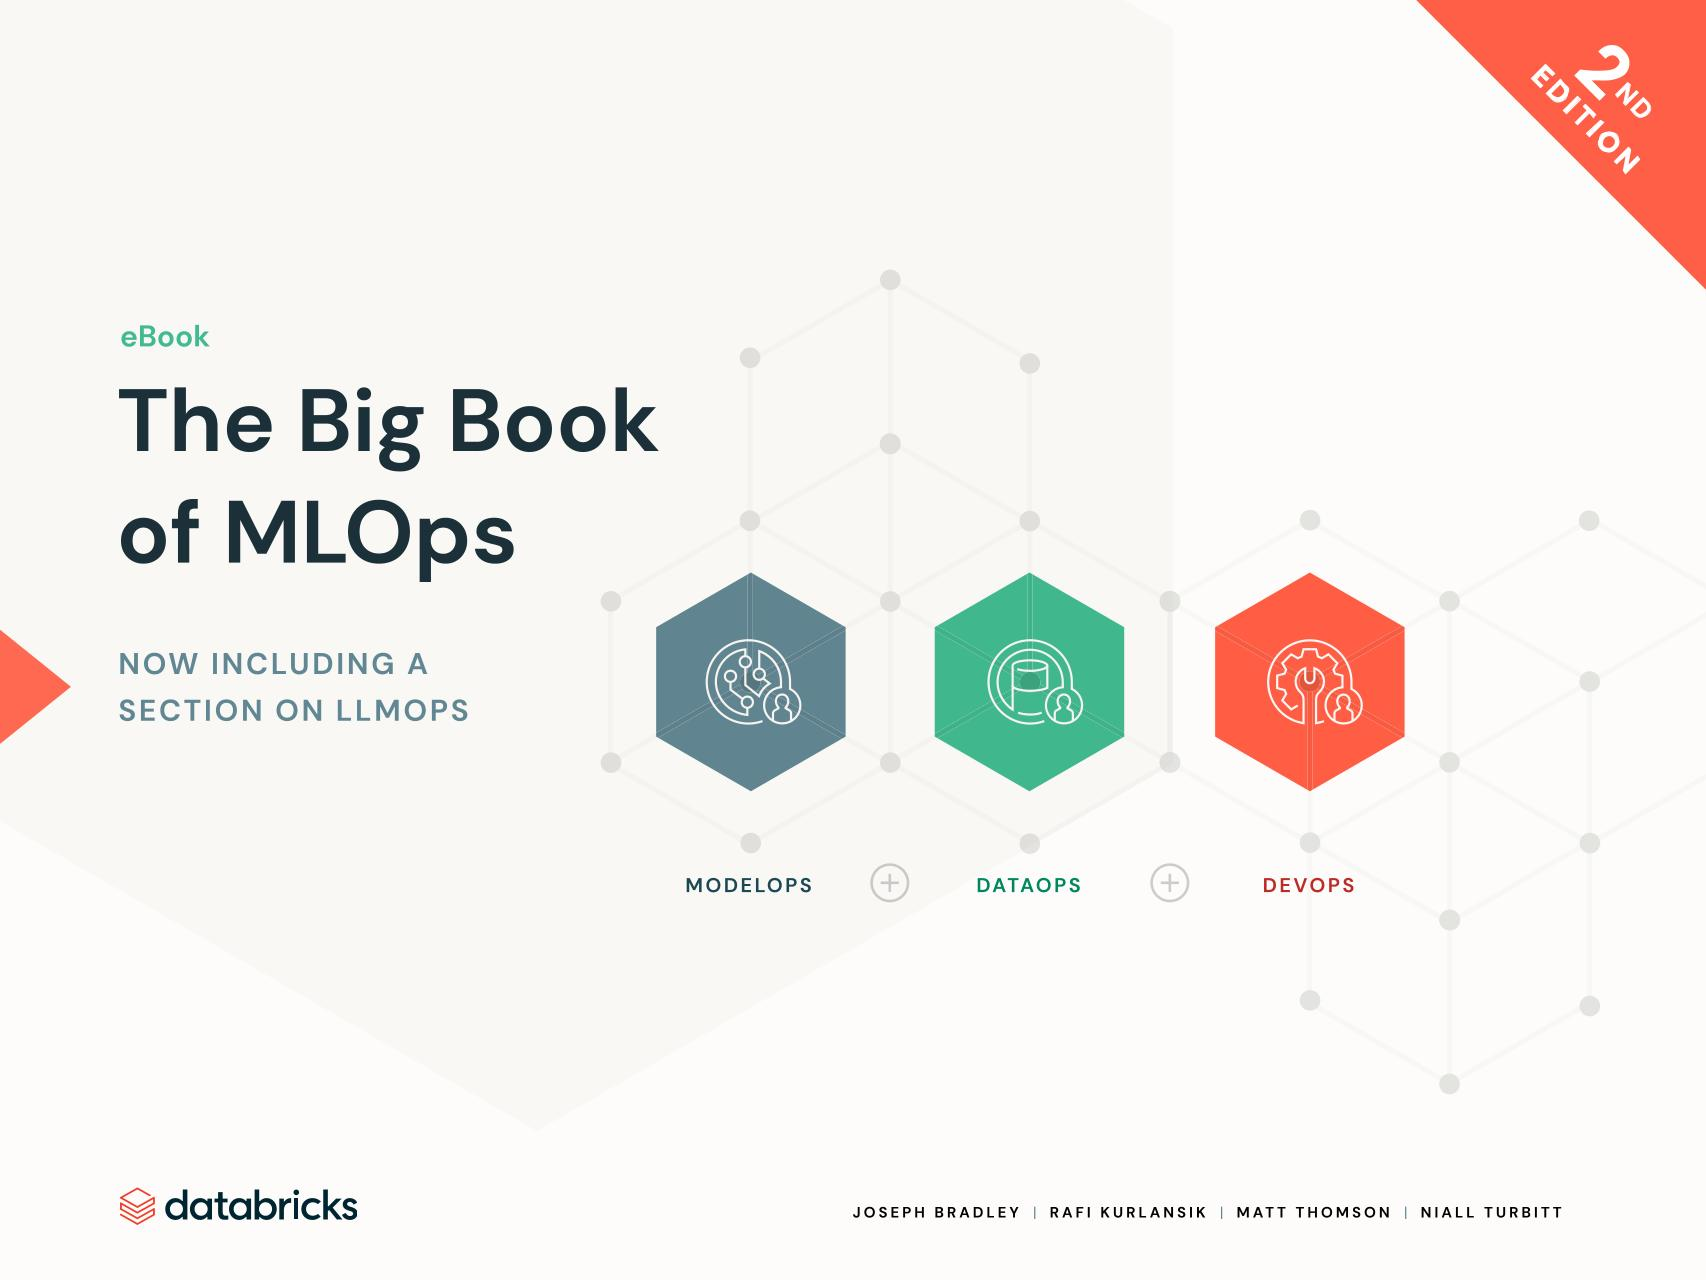


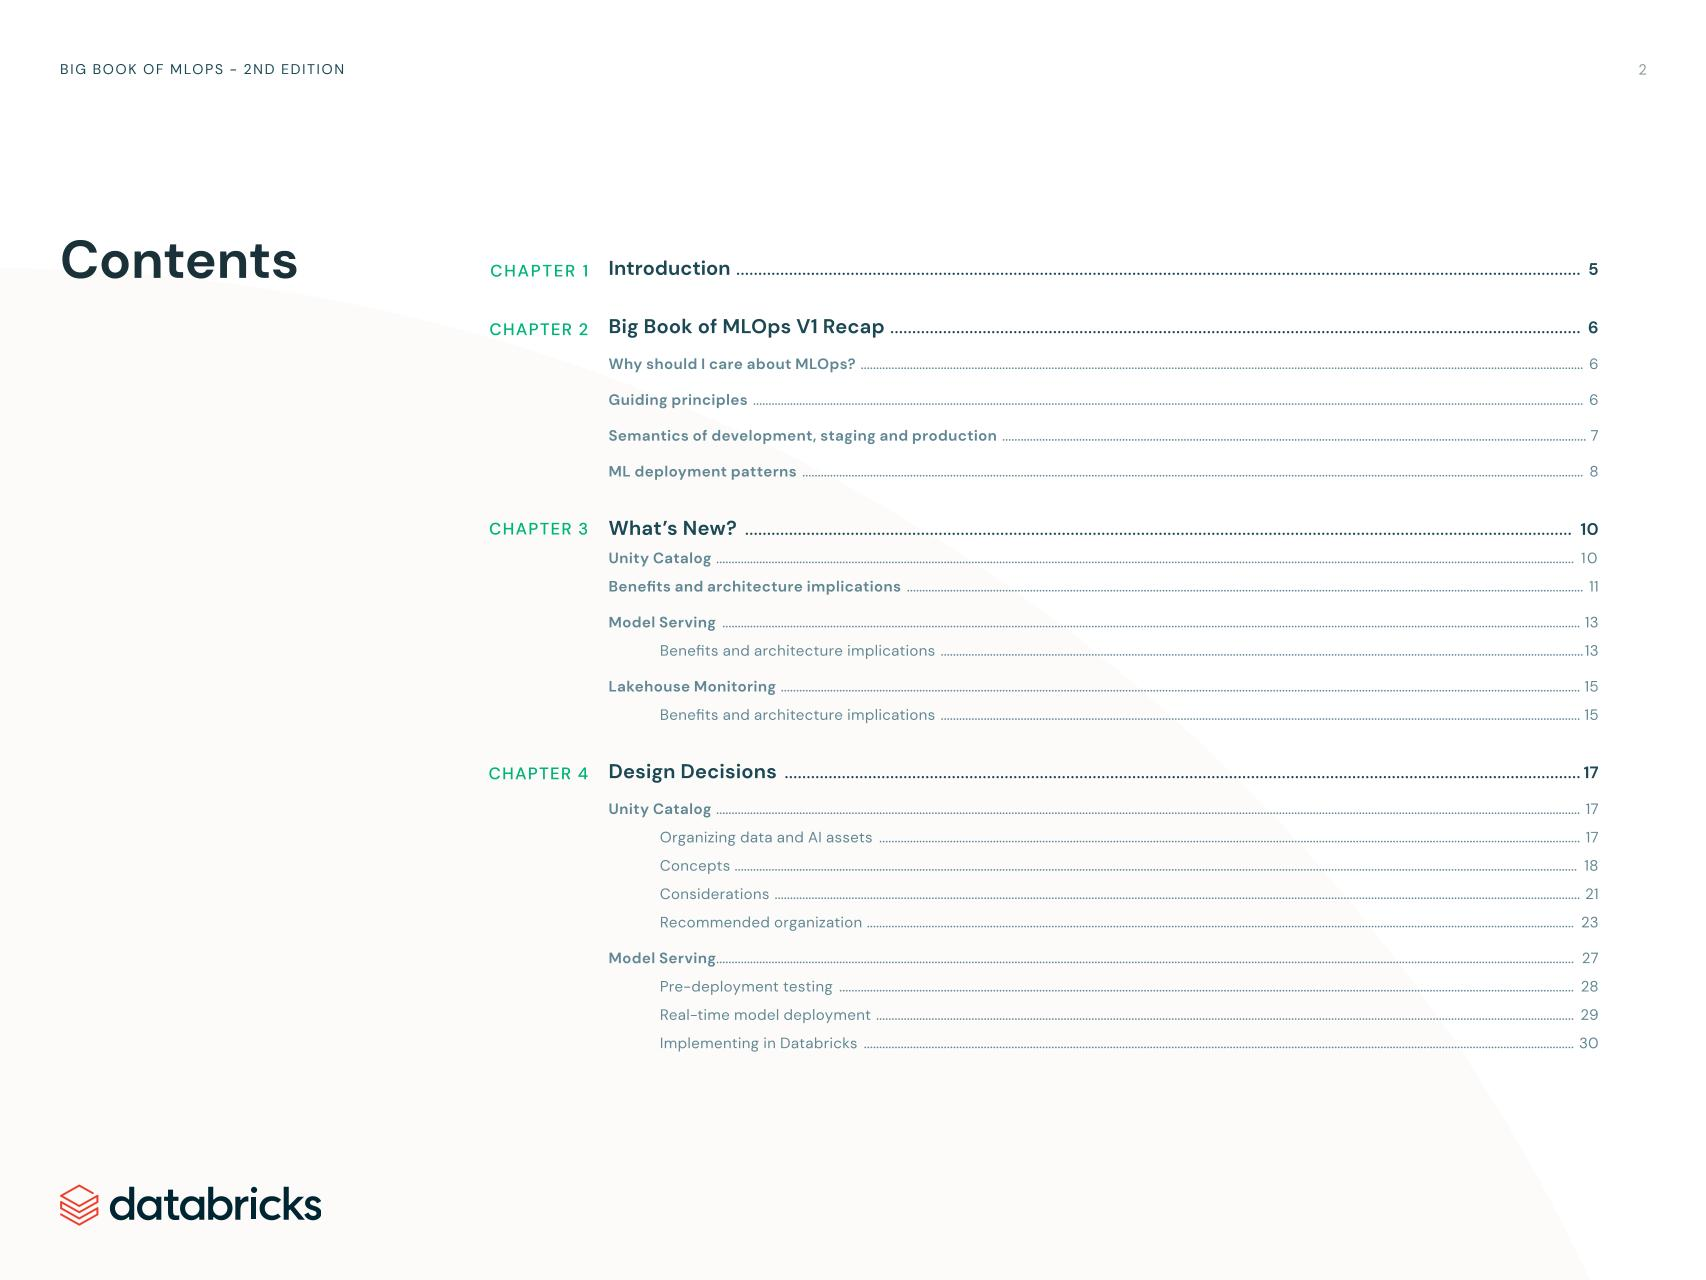


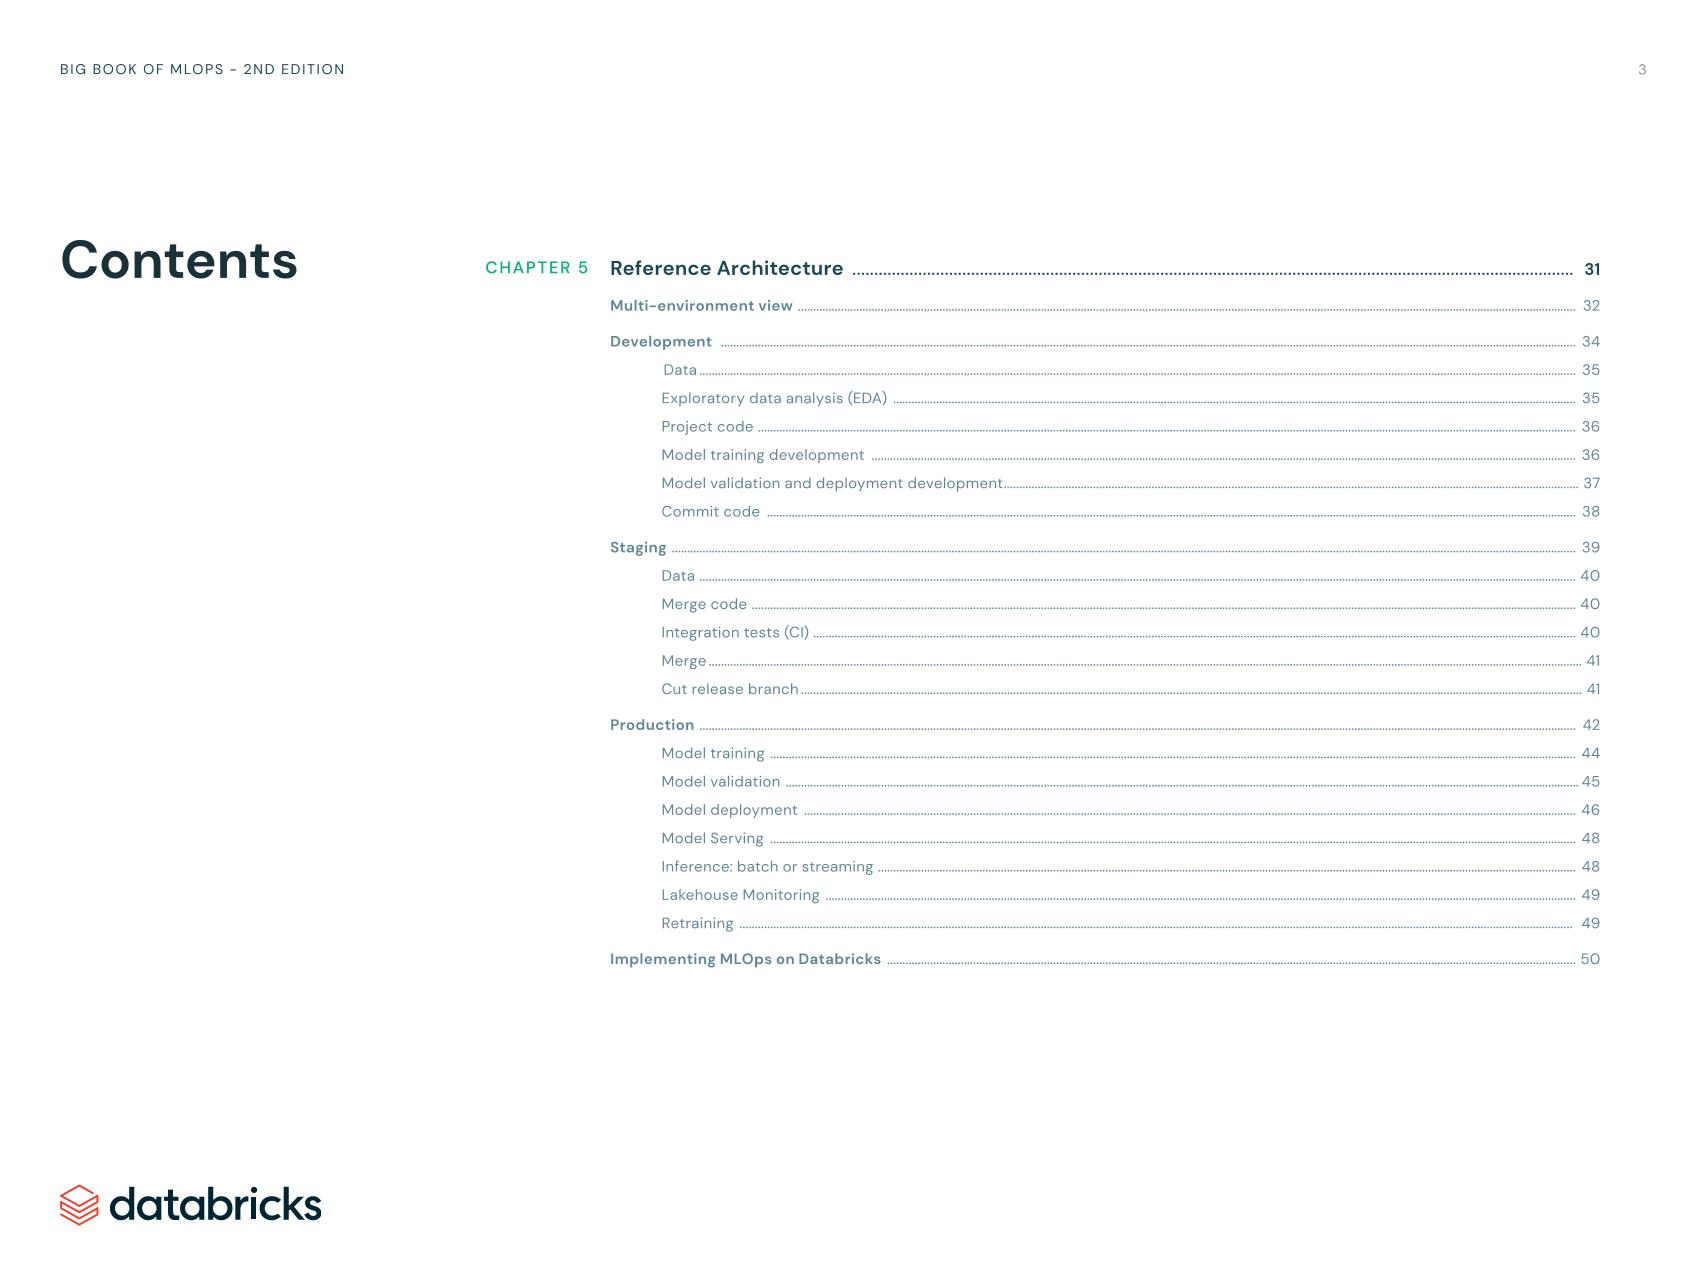


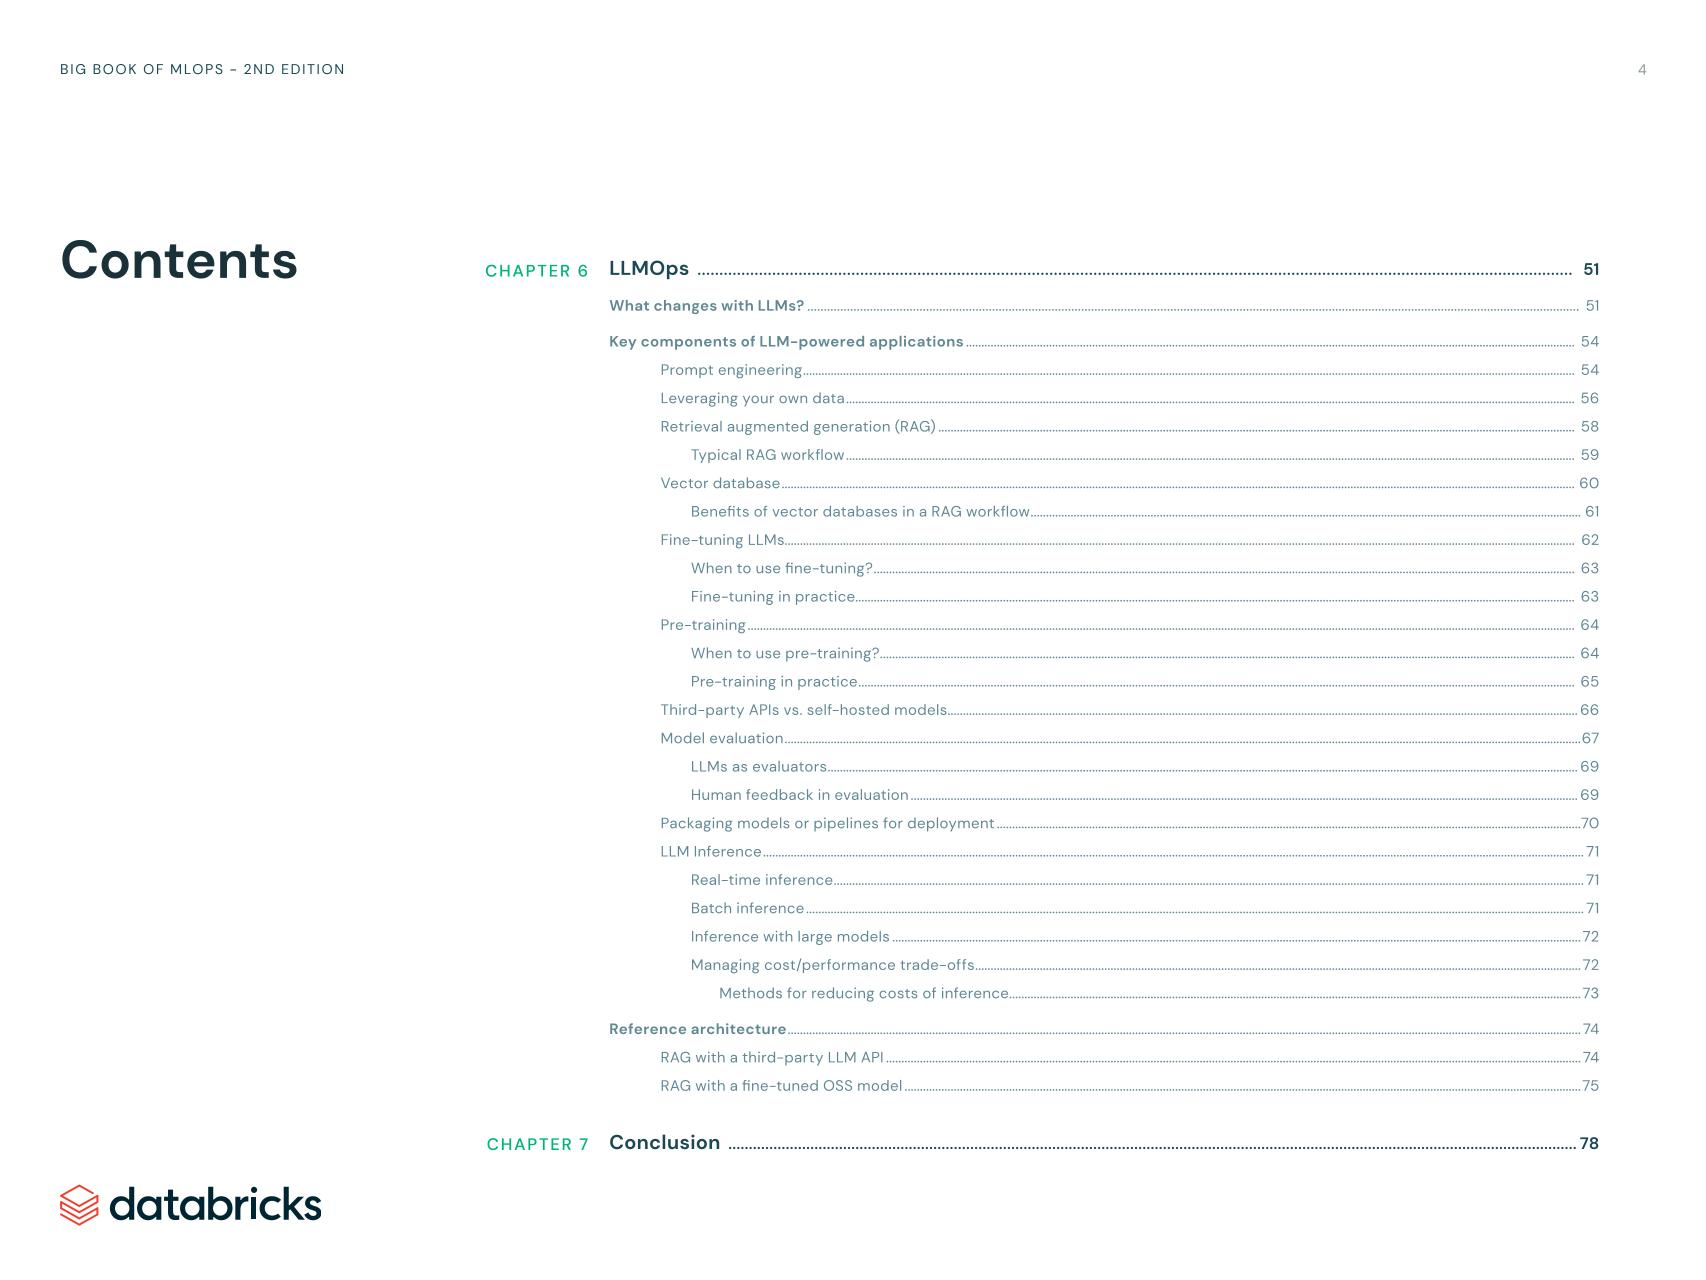


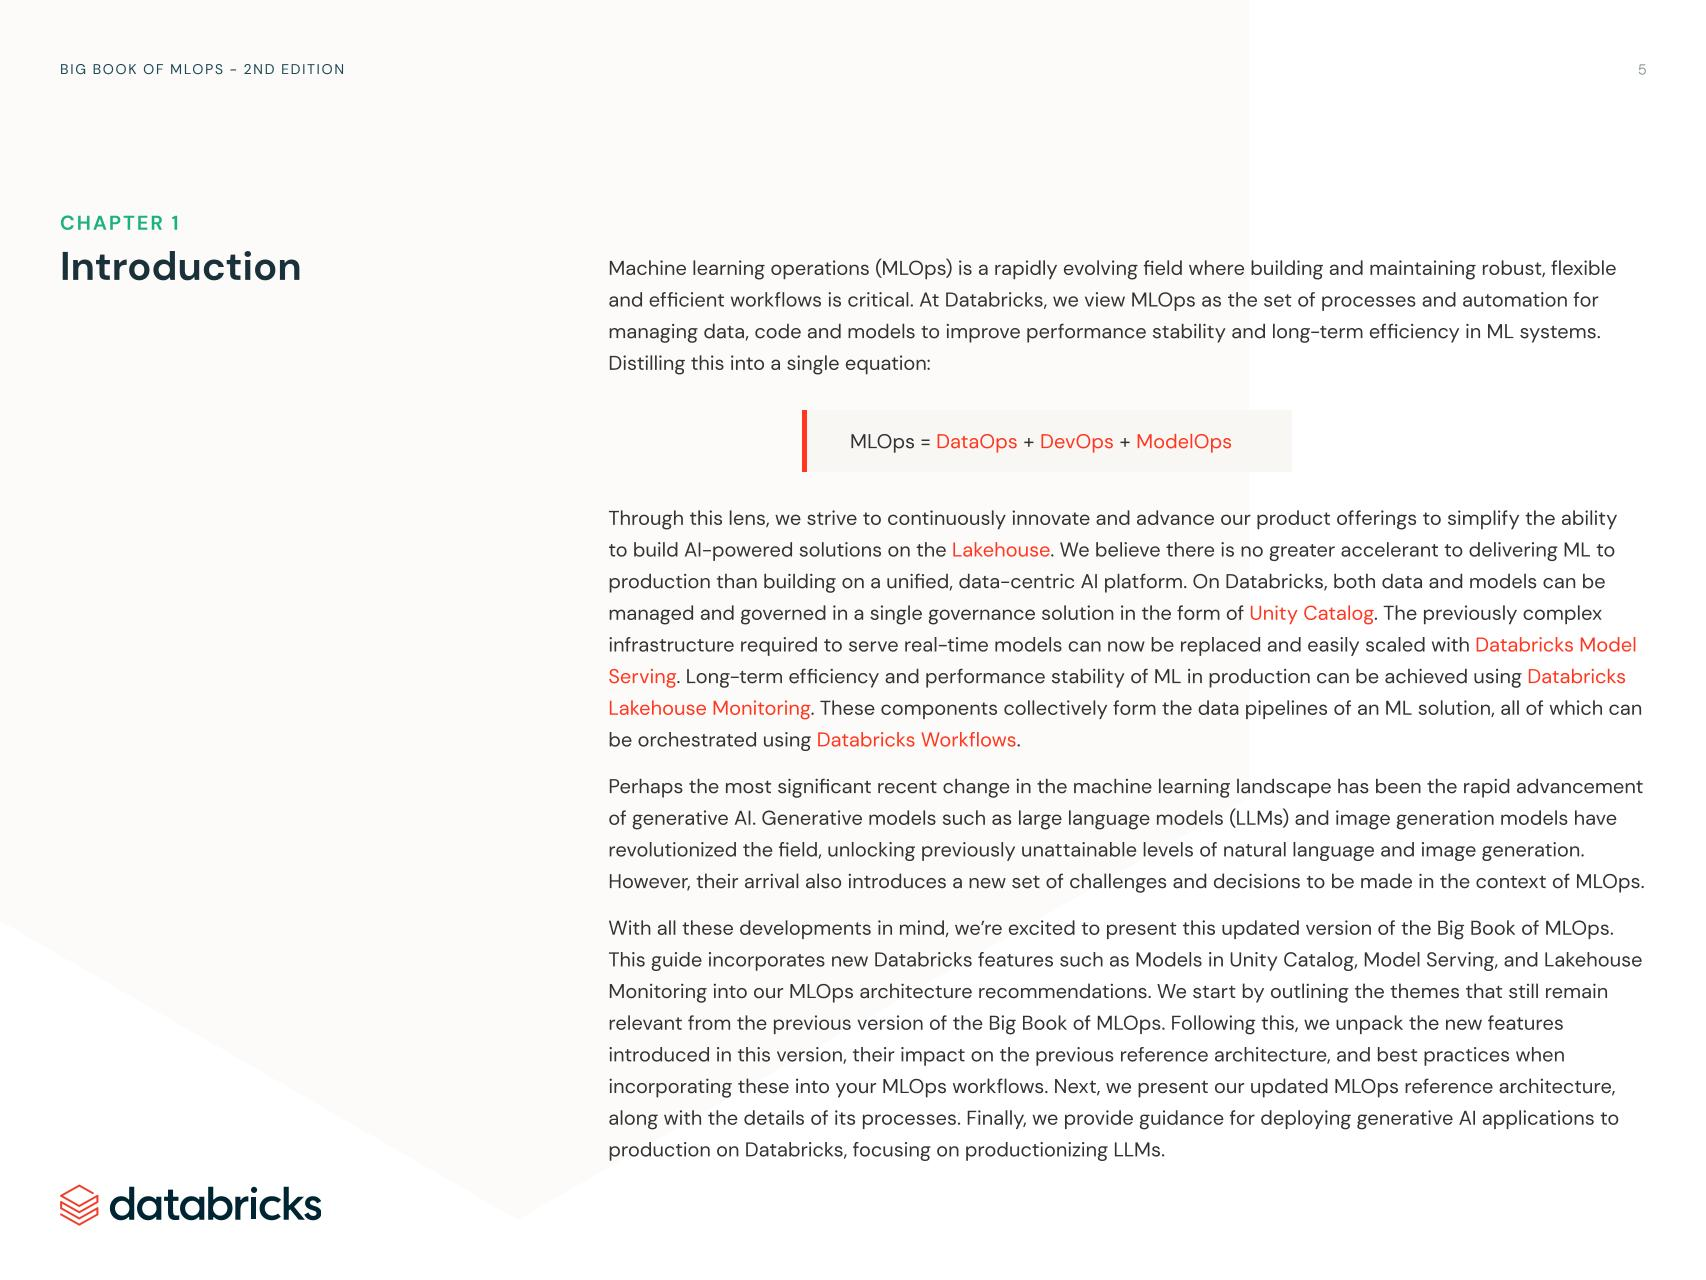


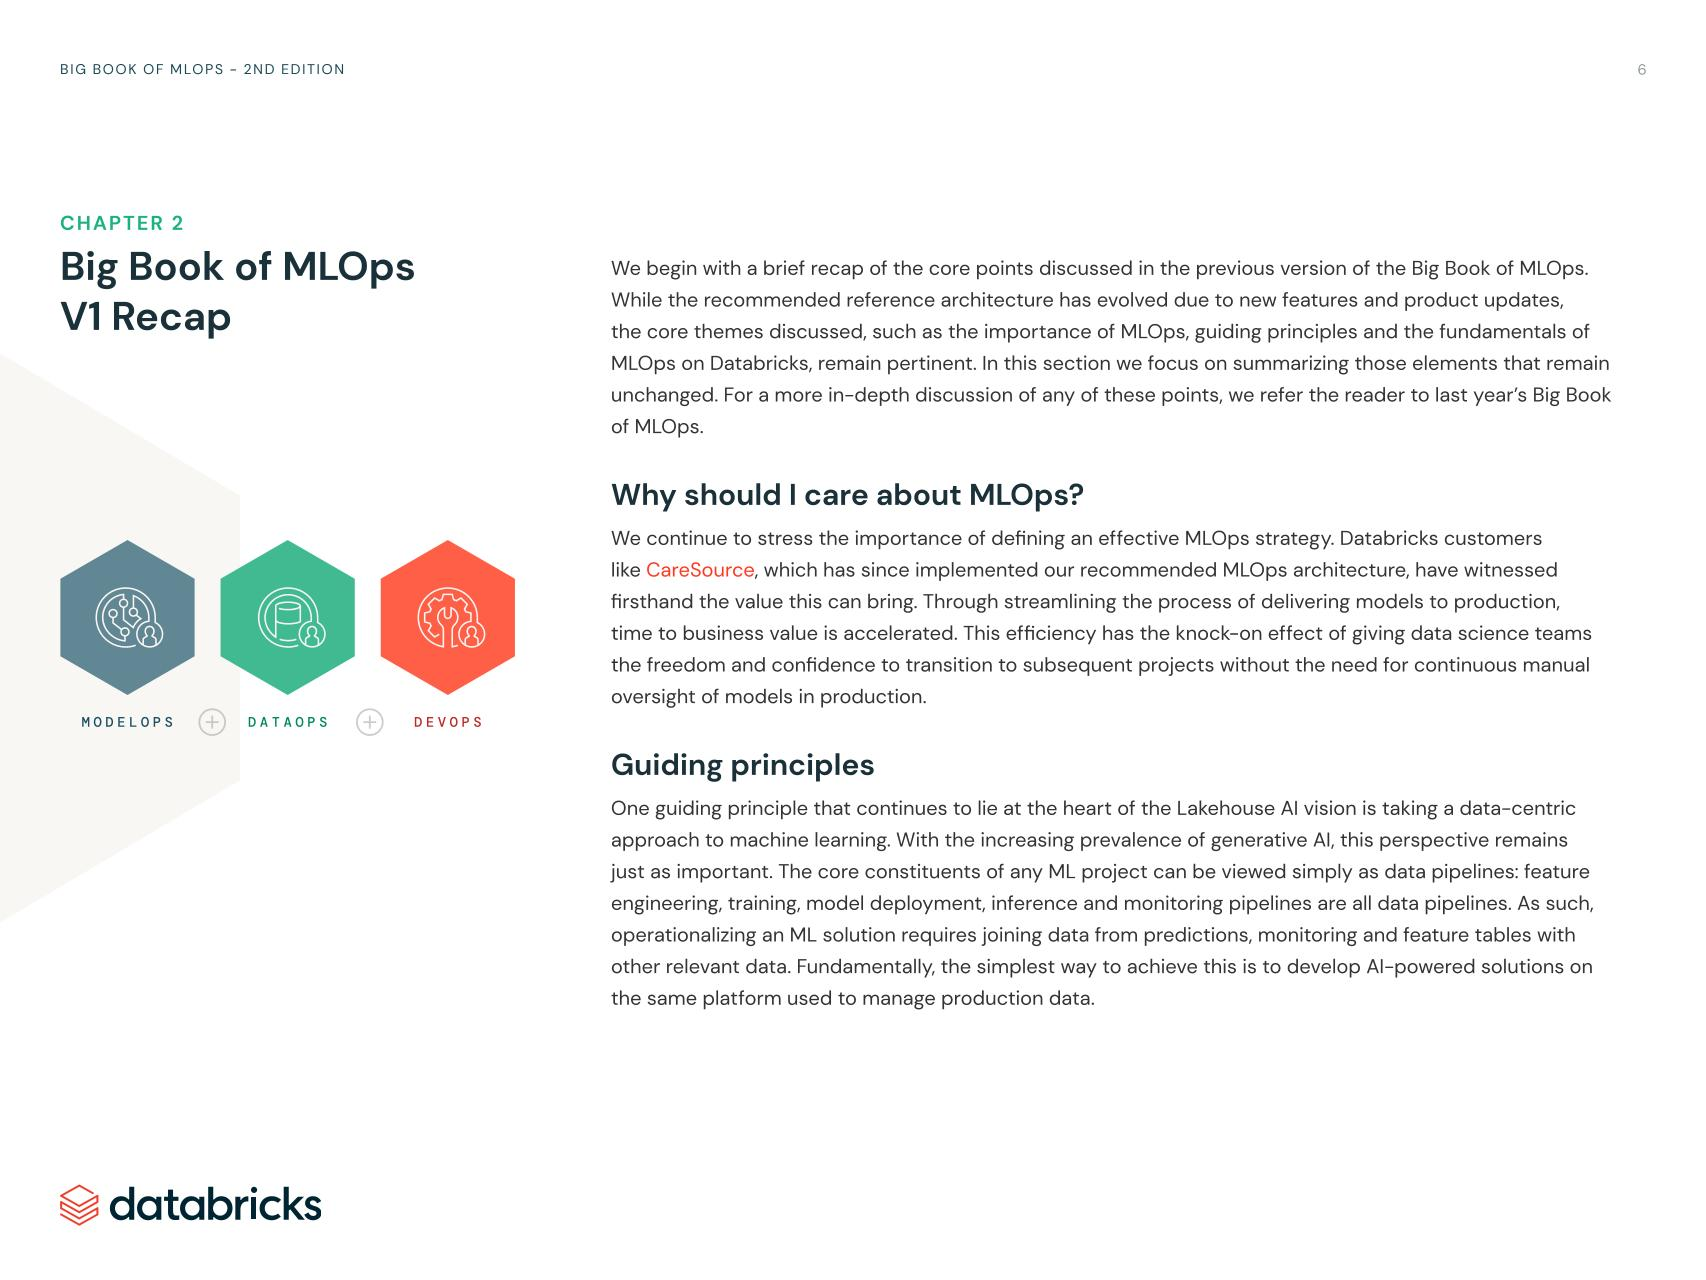


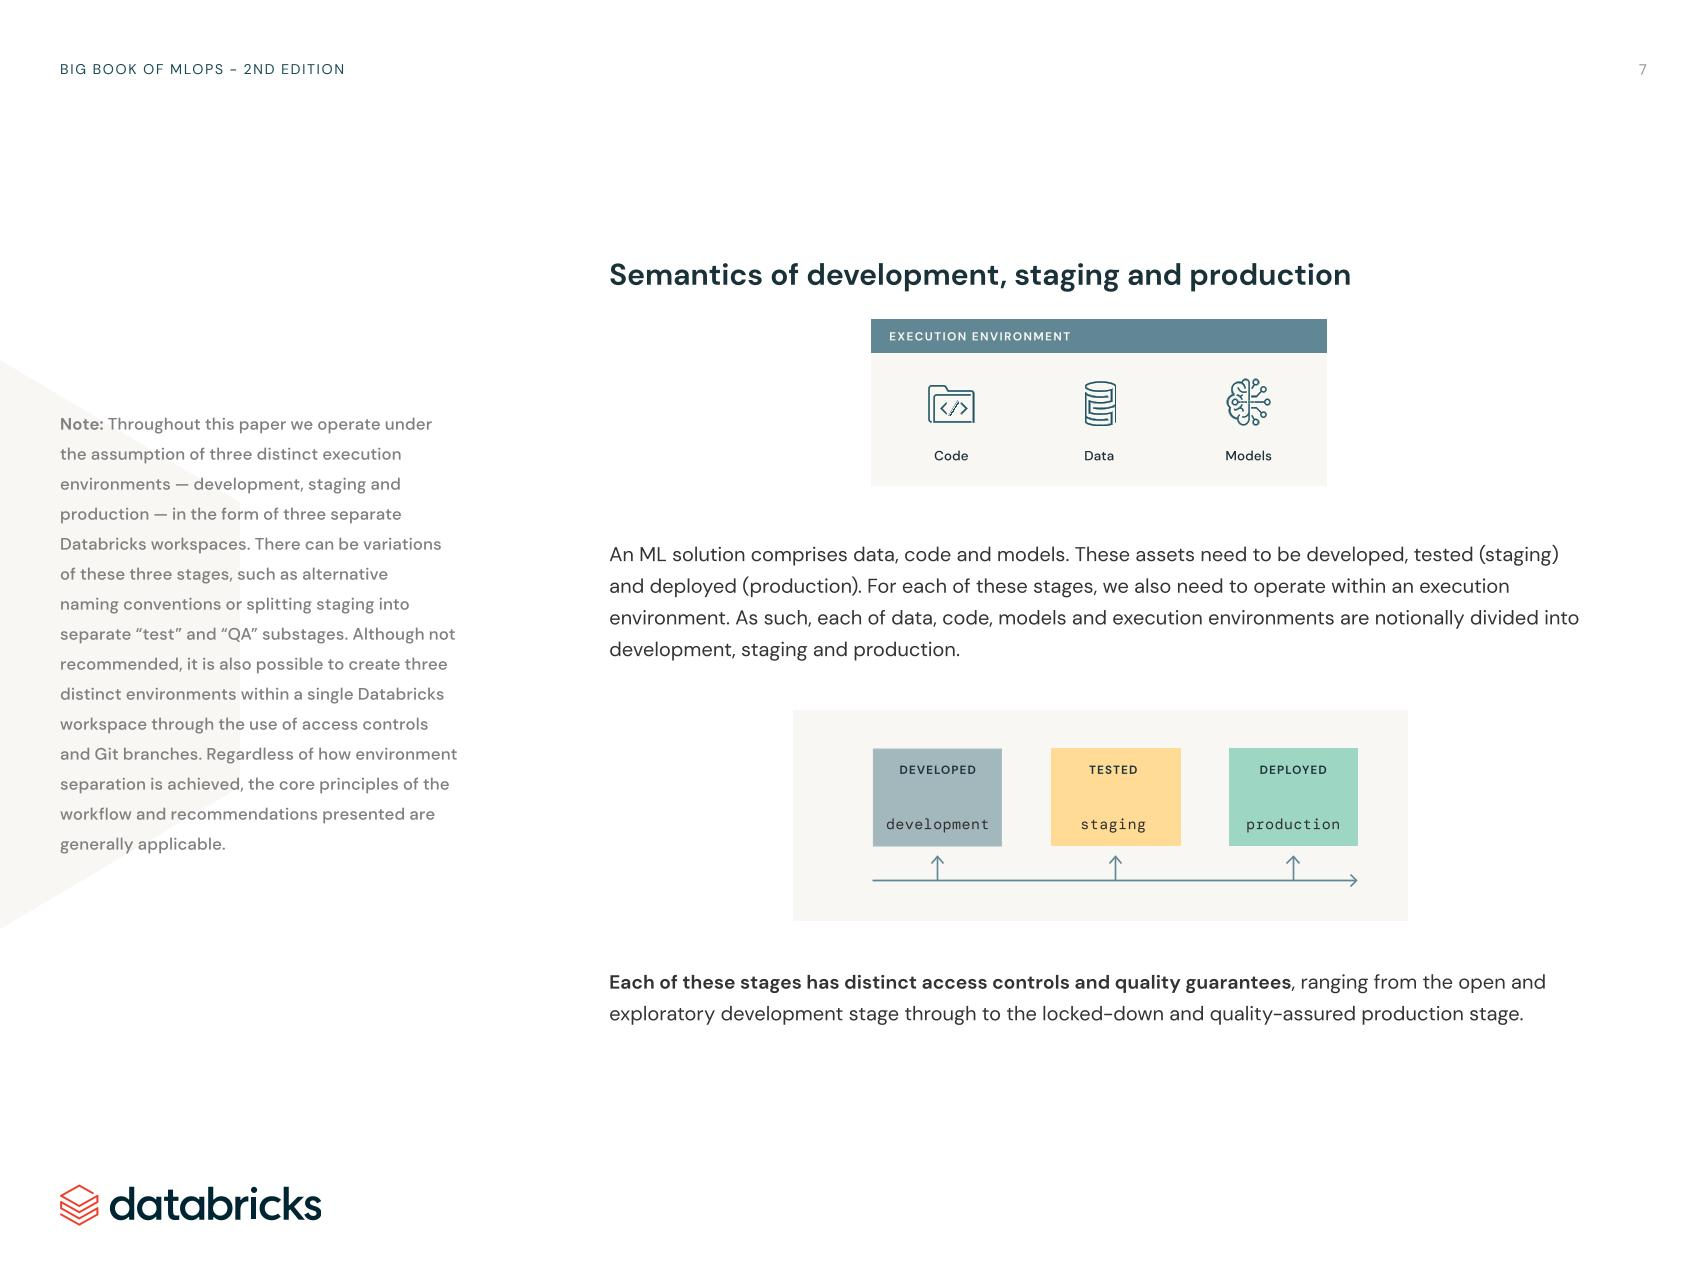


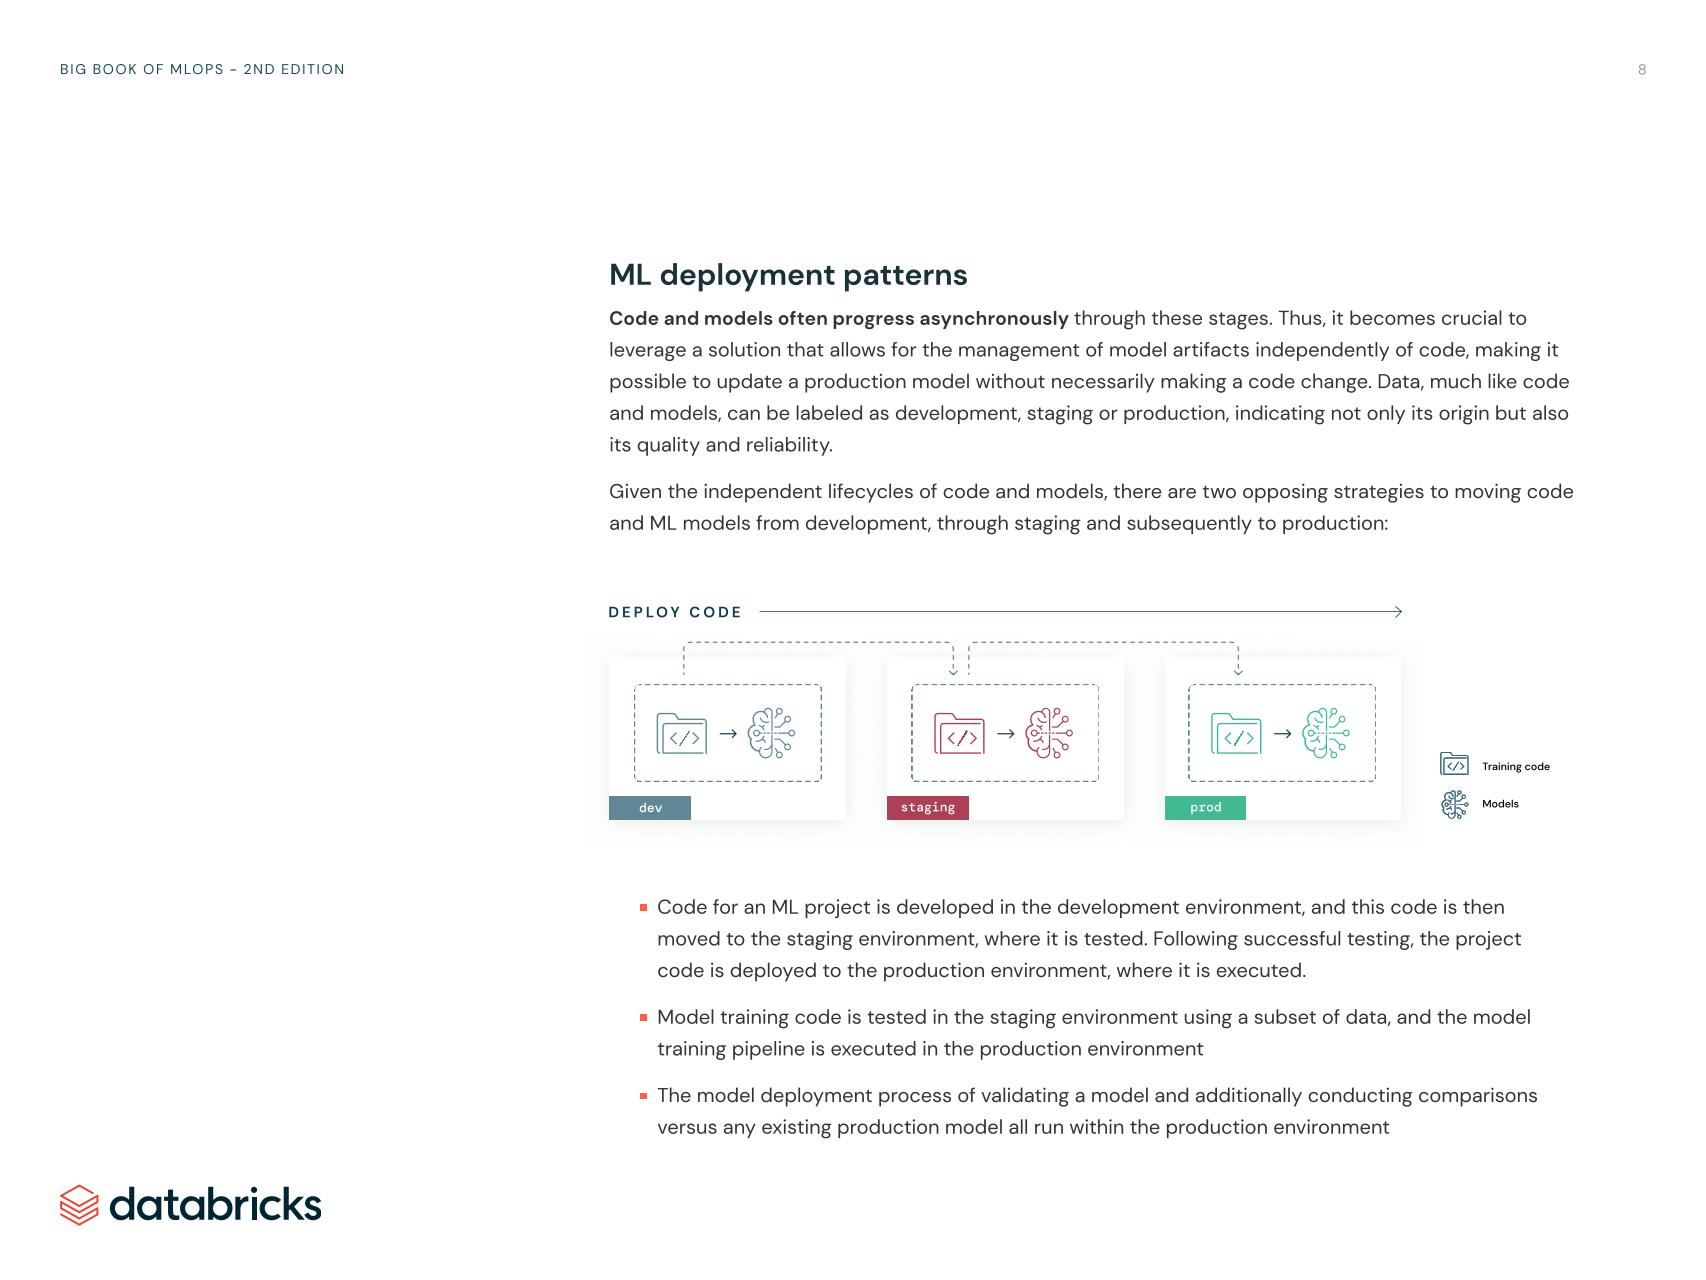


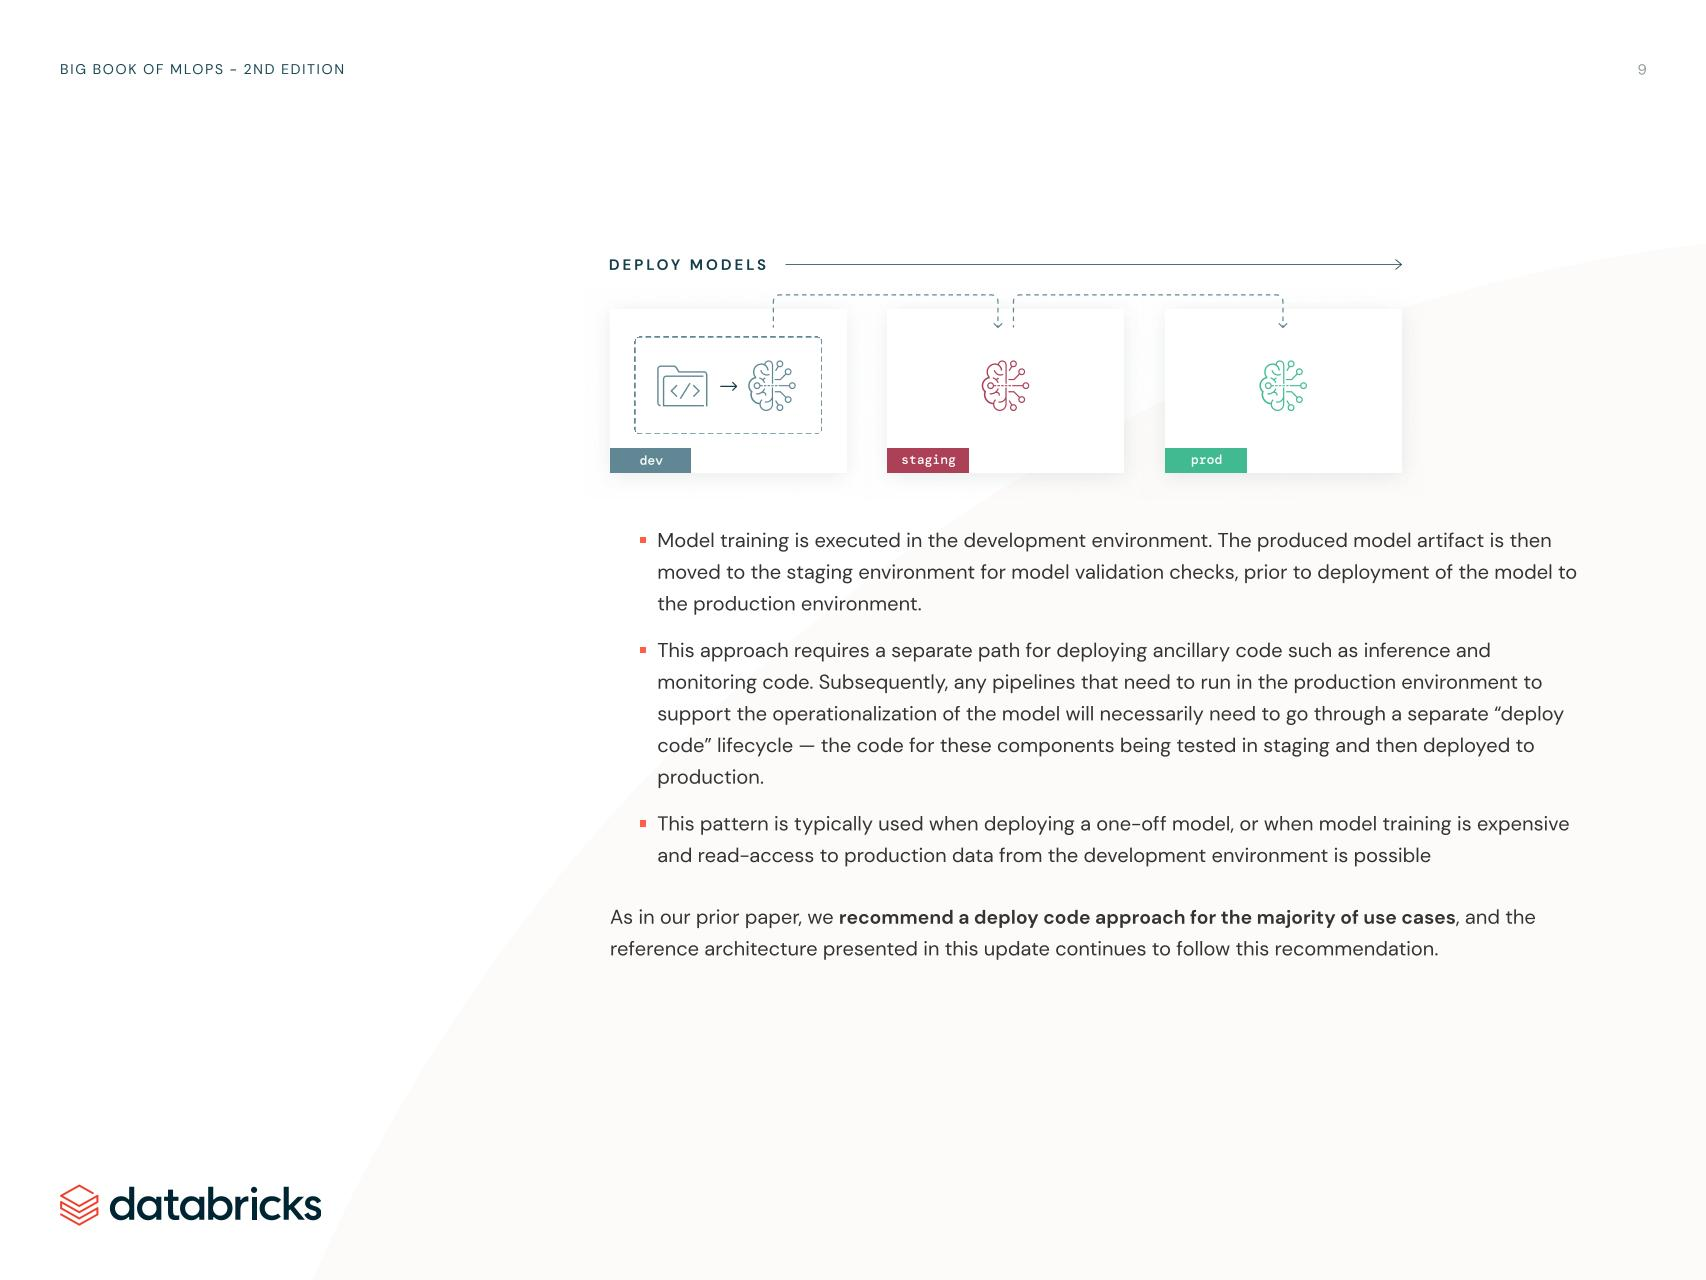


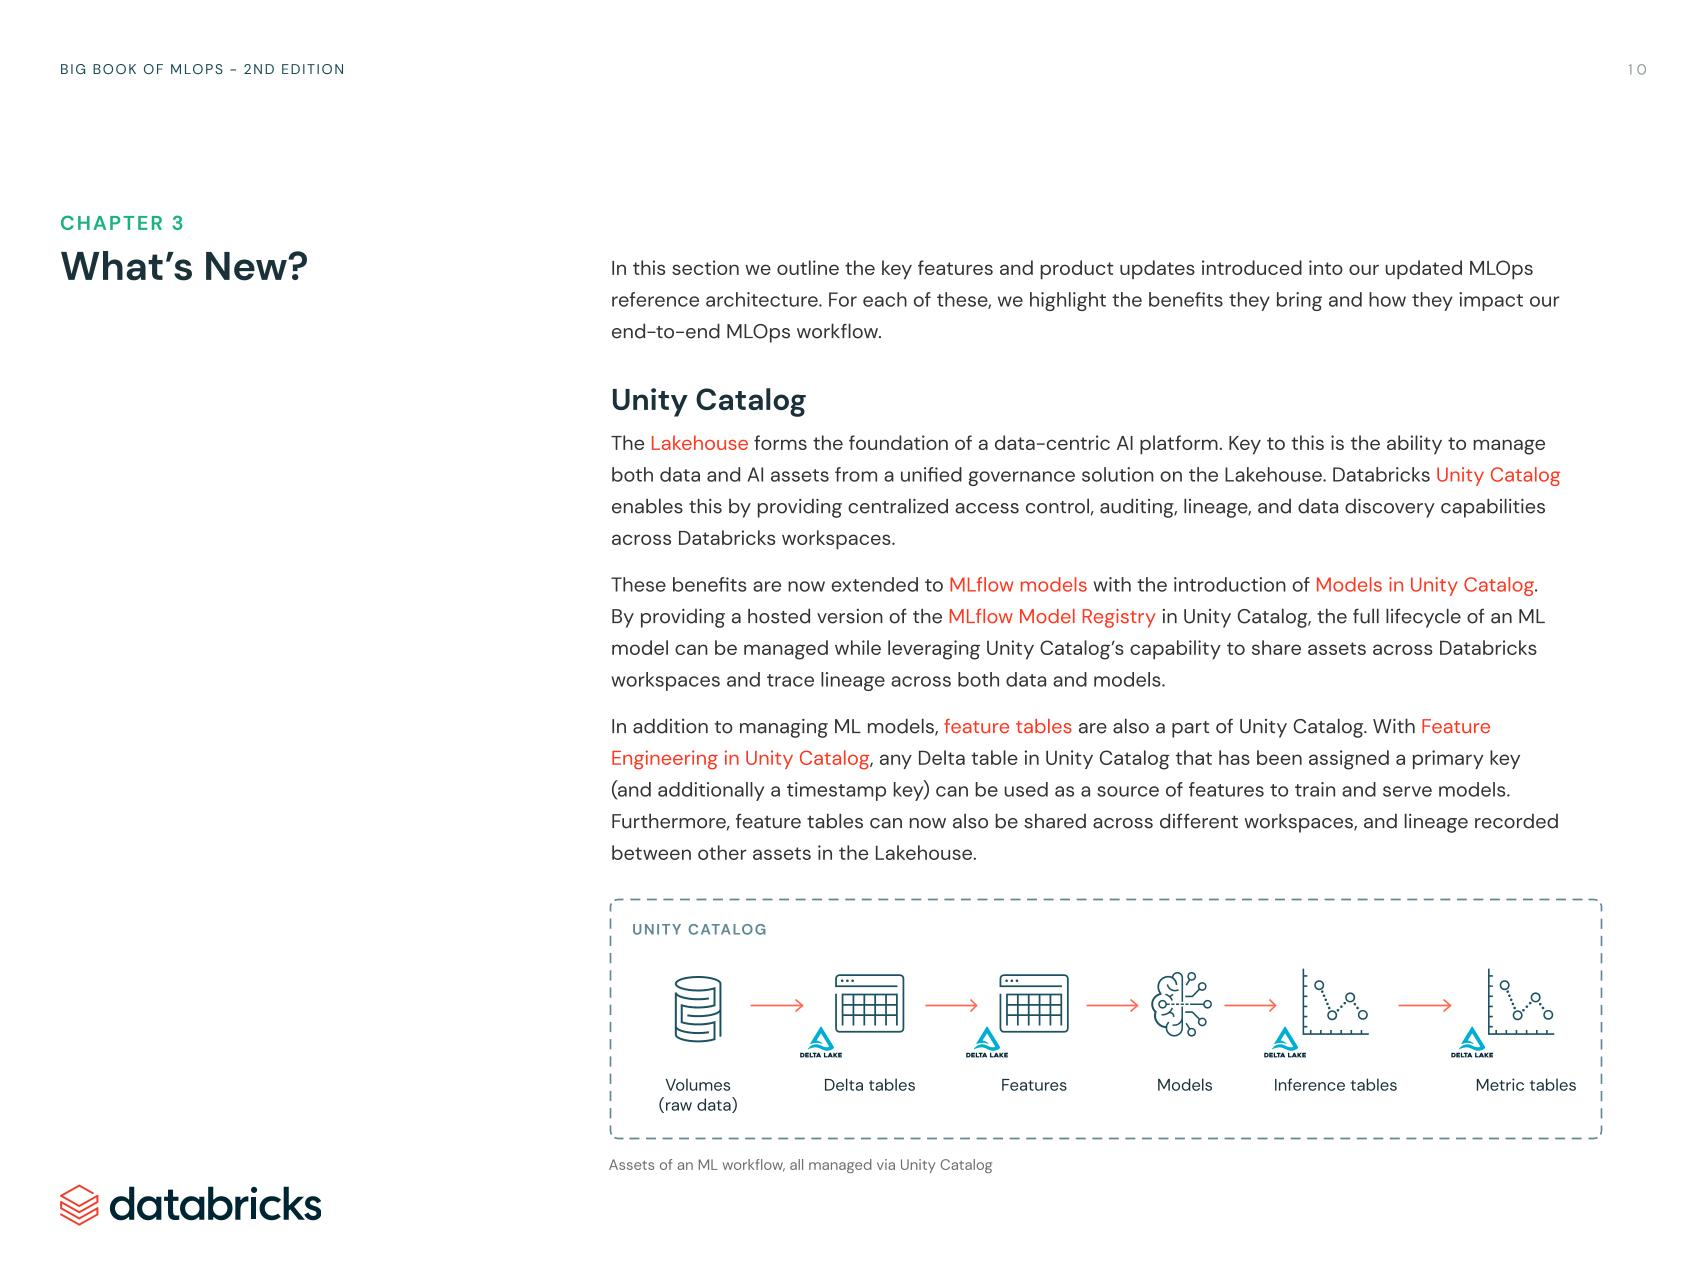

In [0]:
for parsed_result in parsed_results:
  render_ai_parse_output(parsed_result, page_selection)